In [4]:
! pip install einops torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.8 MB/s eta 0:00:00


In [5]:
import sys
sys.path.append("./../")
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score, recall_score
import math
from PIL import Image
import time
from scipy.io import loadmat as loadmat
import h5py
from scipy import io
import random
import numpy as np
import os
import shutil
from tqdm.notebook import tqdm
import torch
import torch.utils.data as dataf
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from operator import truediv
import pandas as pd
import spectral
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
cudnn.benchmark = False
from einops import rearrange, repeat
import copy
import time
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
from torch import einsum
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
cudnn.benchmark = False
cudnn.enabled = False
from sklearn.decomposition import PCA

In [6]:
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

In [7]:
data_file = "/kaggle/input/muufldata/muufl_data.mat"
data = loadmat(data_file)
data.keys()
# X.shape

dict_keys(['__header__', '__version__', '__globals__', 'descriptipn', 'hsi_img', 'labels', 'lidarZ', 'rgb'])

In [8]:
data['descriptipn']

array([[array(['trees'], dtype='<U5'),
        array(['grass_pure'], dtype='<U10'),
        array(['grass_groundsurface'], dtype='<U19'),
        array(['dirt_and_sand'], dtype='<U13'),
        array(['road_materials'], dtype='<U14'),
        array(['water'], dtype='<U5'),
        array(['shadow_building'], dtype='<U15'),
        array(['buildings'], dtype='<U9'),
        array(['sidewalk'], dtype='<U8'),
        array(['yellowcurb'], dtype='<U10'),
        array(['cloth_panels'], dtype='<U12')]], dtype=object)

In [9]:
data['hsi_img'][()].shape

(325, 220, 64)

In [10]:
X = data['hsi_img'][()]
y = data['labels'][()]

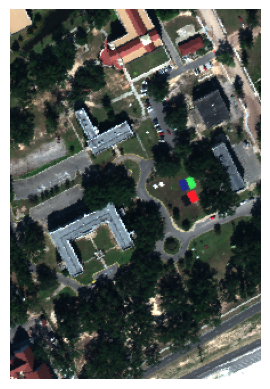

In [11]:
plt.imshow(data['rgb'][()])
plt.axis('off')  
plt.show()

In [12]:
y.shape

(325, 220)

In [13]:
y[y == -1] = 0

In [14]:
np.max(y), np.min(y)

(11, 0)

In [15]:
X.shape, y.shape

((325, 220, 64), (325, 220))

In [16]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [17]:
# plotting the data
def plot_hsi_step(X, step=1):
    """
    Plot the hyperspectral image with a specified step between bands.

    Args:
      X (numpy.ndarray): The hyperspectral image data with shape [num_rows, num_cols, num_bands].
      step (int): Step size between bands for plotting. Default is 1.
    """
    end_band = X.shape[-1]

    # reshaping the hyperspectal image data
    # in our case X.shape = [145,145,200]
    num_rows, num_cols, _ = X.shape
    # num_cols = num_rows = 145
    reshaped_data = np.moveaxis(X[:, :, 0:end_band:step], -1, 0)
    #it's moving the last axis (bands) to the first position because imshow expects the bands to be the first dimension of the array

    num_bands_to_plot = reshaped_data.shape[0]
    fig, axs = plt.subplots(nrows=1, ncols=num_bands_to_plot, figsize=(15, 5))
    for i in range(num_bands_to_plot):
        axs[i].imshow(reshaped_data[i], cmap='gray')
        axs[i].set_title(f'Band {i * step}')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

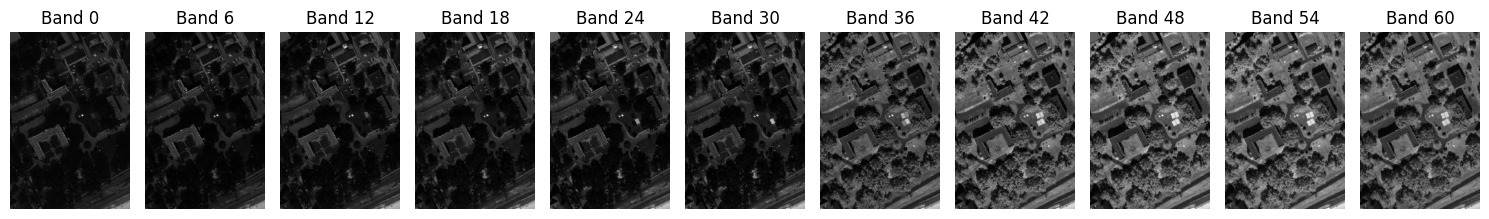

In [18]:
plot_hsi_step(X, 6)

In [19]:
def sample_gt(gt, train_rate):
    """
    Generate training and testing ground truth class maps based on a given full class map.

    Args:
    gt (numpy.ndarray): Full class map.
    train_rate (float): Ratio of training dataset.

    Returns:
    train_gt (numpy.ndarray): Class map of training data.
    test_gt (numpy.ndarray): Class map of testing data.
    """
    # getting the indices of non-zero elements in the ground truth class map
    indices = np.nonzero(gt)  # returns a tuple of arrays containing indices where gt is non-zero ([x1,x2,...],[y1,y2,...])
    X = list(zip(*indices))  # converting the tuple of arrays into a list of tuples containing pixel locations X=[(x1,y1),(x2,y2),...] location of pixels (basically transpose)
    y = gt[indices].ravel()  # getting the corresponding non-zero class labels and flatten them

    # initialize arrays to store the class maps for training and testing data
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)

    if train_rate > 1:
        train_rate = int(train_rate)

    # splittin the data into training and testing sets
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    # the stratify=y parameter ensures that the splitting process preserves the proportion of samples for each class label as in the original data

    # convert the list of tuples back into separate lists of x and y coordinates
    train_indices = [t for t in zip(*train_indices)] # ([x1,x2,...],[y1,y2,...])
    test_indices = [t for t in zip(*test_indices)]

    # set the corresponding elements in the training and testing class maps to the non-zero class labels
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]

    return train_gt, test_gt


In [20]:
TRAIN_RATIO = 0.1
VAL_RATIO = 0.1

In [21]:
train_gt, test_gt = sample_gt(y,TRAIN_RATIO)
val_gt,test_gt = sample_gt(test_gt,VAL_RATIO/(1-TRAIN_RATIO))

In [22]:
train_gt.shape, test_gt.shape, val_gt.shape

((325, 220), (325, 220), (325, 220))

In [23]:
def print_sample_report(train_gt, val_gt, test_gt, y):
    """
    Prints a sample report showing the distribution of samples across different datasets and classes.

    Args:
        train_gt (numpy.ndarray): Ground truth classmap for training data.
        val_gt (numpy.ndarray): Ground truth classmap for validation data.
        test_gt (numpy.ndarray): Ground truth classmap for test data.
        y (numpy.ndarray): Array containing class labels.
    """
    sample_report = f"{'class': ^10}{'train_num':^10}{'val_num': ^10}{'test_num': ^10}{'total': ^10}\n"
    for i in np.unique(y):
        if i == 0:
            continue
        sample_report += f"{i: ^10}{(train_gt == i).sum(): ^10}{(val_gt == i).sum(): ^10}{(test_gt == i).sum(): ^10}{(y == i).sum(): ^10}\n"

    sample_report += f"{'total': ^10}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(val_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(y): ^10}"
    print(sample_report)


In [24]:
print_sample_report(train_gt, val_gt, test_gt, y)

  class   train_num  val_num   test_num   total   
    1        2324      2324     18598     23246   
    2        427       427       3416      4270   
    3        688       688       5506      6882   
    4        183       182       1461      1826   
    5        669       669       5349      6687   
    6         47        47       372       466    
    7        223       223       1787      2233   
    8        624       624       4992      6240   
    9        138       139       1108      1385   
    10        18        18       147       183    
    11        27        27       215       269    
  total      5368      5368     42951     53687   


In [25]:
def display_samples(train_gt, val_gt, test_gt):
    """
    Display samples of ground truth classmaps for training, validation, and test data.

    Args:
        train_gt (ndarray): Ground truth classmap for training data.
        val_gt (ndarray): Ground truth classmap for validation data.
        test_gt (ndarray): Ground truth classmap for test data.
    """
    spectral.imshow(classes=train_gt, title='train_gt')
    spectral.imshow(classes=val_gt, title='val_gt')
    spectral.imshow(classes=test_gt, title='test_gt')


/opt/conda/lib/python3.10/site-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


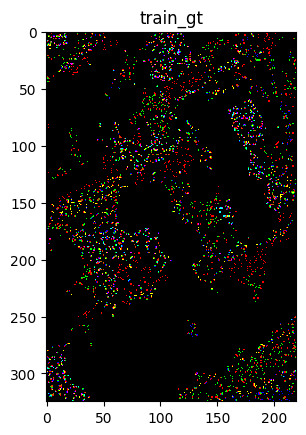

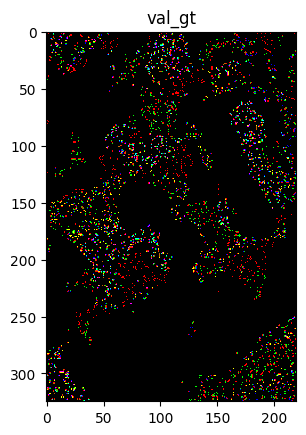

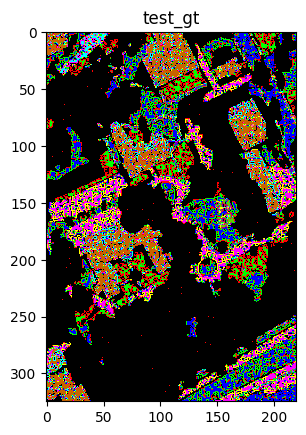

In [26]:
display_samples(train_gt, val_gt, test_gt)

In [27]:
class PatchSet(Dataset):
    """Generate 3D patches from a hyperspectral dataset."""

    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Initialize the PatchSet dataset.

        Args:
            data (ndarray): 3D hyperspectral image.
            gt (ndarray): 2D array of labels.
            patch_size (int): Size of the 3D patch.
            is_pred (bool): Whether to create data without labels for prediction. Default is False.
        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2

        # Padding the data and ground truth arrays
        self.data = np.pad(data, pad_width=((p, p), (p, p), (0, 0)), mode='constant', constant_values=0)
        """
        pad_width: A tuple specifying the padding width for each dimension. In this case, (p, p) is used for both the first and second
                   dimensions (rows and columns), and (0, 0) is used for the third dimension (channels). This means that p pixels will be added to
                   the beginning and end of each row and column, and no padding will be added to the channels dimension.

        mode='constant': Specifies the padding mode. Here, it's set to 'constant', which means that values will be padded with a constant value.

        constant_values=0: Specifying the constant value that will be used for padding.
        """
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt, pad_width=(p, p), mode='constant', constant_values=0)
        """
        pad_width: A tuple specifying the padding width for each dimension. Here, (p, p) is used, indicating that p pixels will be added to
                   the beginning and end of each row and column.
        """

        # Get indices of non-zero values in ground truth
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p  # adjust indices after padding
        self.indices = np.array([(x, y) for x, y in zip(x_pos, y_pos)])

        # Randomly shuffle indices if not predicting
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.indices)

    def __getitem__(self, i):
        """Get a sample from the dataset."""
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size

        # Extract the patch and label from the data and ground truth arrays
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]

        # Transpose the data to match PyTorch format
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')

        # Convert data and label to PyTorch tensors
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)

        # Return data and label (or just data if predicting)
        if self.is_pred:
            return data
        else:
            return data, label


In [28]:
PATCH_SIZE = 8
BATCH_SIZE = 64

In [29]:
train_data = PatchSet(X, train_gt, PATCH_SIZE)
val_data = PatchSet(X, val_gt, PATCH_SIZE)
test_data = PatchSet(X, test_gt, PATCH_SIZE)
all_data = PatchSet(X, y, PATCH_SIZE,is_pred = True)
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle= True)
val_loader = DataLoader(val_data,BATCH_SIZE,shuffle= True)
test_loader = DataLoader(test_data,114,shuffle= False)
all_loader = DataLoader(all_data,BATCH_SIZE,shuffle= False)

In [30]:
len(all_data)

71500

In [31]:
all_data[0].shape

torch.Size([64, 8, 8])

In [32]:
len(test_data)

42951

In [33]:
for batch in all_loader:
    print(type(batch))  # Should be tuple if (data, labels), or tensor if only data
    break

<class 'torch.Tensor'>


In [34]:
for batch in all_loader:
    print(batch.shape)
    break

torch.Size([64, 64, 8, 8])


In [35]:
len(val_data)

5368

In [36]:
d, g = train_data.__getitem__(0)
d.shape, g

(torch.Size([64, 8, 8]), tensor(3))

In [37]:
BAND = 64
CLASSES_NUM = 11

In [38]:
print('-----Importing Setting Parameters-----')
PATCH_LENGTH = 5
lr, num_epochs, batch_size = 0.001, 200, 32

img_rows = 2 * PATCH_LENGTH + 1
print(img_rows)
img_cols = 2 * PATCH_LENGTH + 1


-----Importing Setting Parameters-----
11


In [39]:
def name_with_msg(instance: nn.Module, msg: str) -> str:
    return f"[{instance.__class__.__name__}] {msg}"

In [40]:
class CoAtNetRelativeAttention(nn.Module):
    """
    CoAtNetRelativeAttention implements multi-head self-attention with relative positional biases.
    
    Args:
        in_dim (int): Each token is represented as a vector of size `in_dim`.
        pre_height (int): Predefined input height.
        pre_width (int): Predefined input width.
        heads (int, optional): Number of attention heads.
        kv_dim (int, optional): Dimension of key and value projections (default: same as `in_dim`).
        head_dim (int, optional): Dimension of each attention head. 
        proj_dim (int, optional): Projection dimension.
        out_dim (int, optional): Output feature dimension (default: same as `in_dim`).
        attention_dropout (float, optional): Dropout rate for attention weights (default: 0.0).
        ff_dropout (float, optional): Dropout rate for the output projection (default: 0.0).
        use_bias (bool, optional): Whether to use bias in linear projections (default: False).
        dtype (torch.dtype, optional): Data type for numerical precision (default: torch.float32).
    """
    def __init__(
        self, 
        in_dim: int,
        pre_height: int,
        pre_width: int,
        *,
        heads: int = None, 
        kv_dim: int = None, 
        head_dim: int = None, 
        proj_dim: int = None,
        out_dim: int = None,
        attention_dropout: float = 0.0, 
        ff_dropout: float = 0.0, 
        use_bias: bool = False,
        dtype=torch.float32, 
        **rest
    ):
        super().__init__()

        # Determine embedding dimension for projections
        dim = proj_dim if proj_dim is not None else in_dim
        out_dim = out_dim if out_dim is not None else in_dim

        # Ensure either `heads` or `head_dim` is provided
        assert (
            heads is not None or head_dim is not None
        ), f"[{self.__class__.__name__}] Either `heads` or `head_dim` must be specified."

        # Derive the number of heads and head dimension if one is missing
        self.heads = heads if heads is not None else dim // head_dim
        head_dim = head_dim if head_dim is not None else dim // self.heads

        # Ensure that the total embedding size matches the product of `heads` and `head_dim`
        assert (
            head_dim * self.heads == dim
        ), f"[{self.__class__.__name__}] Head dimension times the number of heads must be equal to embedding dimension (`in_dim` or `proj_dim`)"
        
        # Define linear layers for Query (Q), Key (K), and Value (V)
        self.Q = nn.Linear(in_dim, dim, bias=use_bias)
        self.K = nn.Linear(kv_dim if kv_dim is not None else in_dim, dim, bias=use_bias)
        self.V = nn.Linear(kv_dim if kv_dim is not None else in_dim, dim, bias=use_bias)
        
        # Output projection layer
        self.out_linear = nn.Linear(dim, out_dim)

        # Dropout layers for attention weights and final output
        self.attention_dropout = nn.Dropout2d(attention_dropout)
        self.out_dropout = nn.Dropout(ff_dropout)

        # Scaling factor for dot-product attention
        self.scale = head_dim ** (-0.5)

        # Mask value for masked attention (very large negative number to nullify masked entries)
        self.mask_value = -torch.finfo(dtype).max  # Pytorch default float type

        # Relative positional encoding parameters
        self.pre_height = pre_height
        self.pre_width = pre_width

        # Define learnable relative bias parameter
        self.relative_bias = nn.Parameter(
            torch.randn(self.heads, int((2*pre_height - 1)*(2*pre_width - 1))),
            requires_grad=True
        )
        
        # Compute relative indices for position encoding
        self.register_buffer("relative_indices", self._get_relative_indices(pre_height, pre_width))

    def forward(self, x, attention_mask=None, verbose=False):
        """
        Forward pass for multi-head attention with relative positional encoding.

        Args:
            x (torch.Tensor or tuple of torch.Tensor): 
                - Shape: (batch_size, channels, height, width) for spatial inputs
                - or (batch_size, seq_len, in_dim) for sequence inputs
            attention_mask (torch.Tensor, optional): Attention mask for sequence inputs
            verbose (bool, optional): If True, print intermediate tensor shapes

        Returns:
            torch.Tensor: Output of the multi-head attention module
        """
        h = self.heads  # Number of attention heads
        
        # Check if input is spatial (4D) or sequential (3D)
        is_spatial = len(x.shape) == 4

        if is_spatial:
            b, c, H, W = x.shape
            # Reshape input for attention mechanism
            x = rearrange(x, "b c h w -> b (h w) c")
        else:
            b, seq_len, c = x.shape
            H, W = seq_len, 1

        if verbose:
            print(f"Input shape after initial processing: {x.shape}")

        # Compute Query, Key, and Value projections
        q, k, v = map(lambda proj: proj(x), (self.Q, self.K, self.V))

        if verbose:
            print(f"Q shape: {q.shape}, K shape: {k.shape}, V shape: {v.shape}")

        # Reshape projections to (batch_size, heads, seq_len, head_dim)
        q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=h), (q, k, v))

        if verbose:
            print(f"Q reshaped: {q.shape}, K reshaped: {k.shape}, V reshaped: {v.shape}")

        # Scale the key vectors
        k = k * self.scale

        # Determine relative biases based on input size
        if H == self.pre_height and W == self.pre_width:
            relative_indices = self.relative_indices
            relative_bias = self.relative_bias
        else:
            relative_indices = self._get_relative_indices(H, W)
            relative_bias = self._interpolate_relative_bias(H, W)

        # Expand indices and biases to match batch and head dimensions
        relative_indices = repeat(relative_indices, "n m -> b h n m", b=b, h=h)
        relative_bias = repeat(relative_bias, "h r -> b h n r", b=b, n=H*W)

        # Gather and apply relative biases
        relative_biases = relative_bias.gather(dim=-1, index=relative_indices)

        # Compute attention scores
        attention = einsum("b h n d, b h m d -> b h n m", q, k) + relative_biases

        # Apply attention mask if provided
        if attention_mask is not None:
            attention_mask = repeat(attention_mask, "b 1 n m -> b h n m", h=h)
            attention.masked_fill_(attention_mask, self.mask_value)

        # Apply softmax to get attention weights
        attention = attention.softmax(dim=-1)
        
        # Apply dropout to attention weights
        attention = self.attention_dropout(attention)
        
        # Compute weighted sum of value vectors
        out = einsum("b h n m, b h m d -> b h n d", attention, v)
        
        # Reshape output to (batch_size, seq_len, heads * head_dim)
        out = rearrange(out, "b h n d -> b n (h d)")
        
        # Apply final linear projection
        out = self.out_linear(out)

        # Apply output dropout
        out = self.out_dropout(out)

        # Reshape back to spatial if input was spatial
        if is_spatial:
            out = rearrange(out, "b (h w) c -> b c h w", h=H, w=W)

        return out

    def _get_relative_indices(self, height: int, width: int) -> torch.Tensor:
        """
        Compute relative position indices for attention biases.
        
        Args:
            height (int): Height of the input feature map.
            width (int): Width of the input feature map.
        
        Returns:
            torch.Tensor: Tensor of relative indices.
        """
        height, width = int(height), int(width)
        ticks_y, ticks_x = torch.arange(height), torch.arange(width)
        grid_y, grid_x = torch.meshgrid(ticks_y, ticks_x)
        out = torch.empty(height*width, height*width).fill_(float("nan"))

        for idx_y in range(height):
            for idx_x in range(width):
                rel_indices_y = grid_y - idx_y + height
                rel_indices_x = grid_x - idx_x + width
                flatten_indices = (rel_indices_y*width + rel_indices_x).flatten()
                out[idx_y*width + idx_x] = flatten_indices

        # Ensure there are no NaN or negative values in indices
        assert not out.isnan().any(), "`relative_indices` contain NaN values"
        assert (out >= 0).all(), "`relative_indices` contain negative indices"
        
        return out.to(torch.long)

    def _interpolate_relative_bias(self, height: int, width: int) -> torch.Tensor:
        """
        Interpolate the relative bias for varying input sizes.
        
        Args:
            height (int): Target height.
            width (int): Target width.
        
        Returns:
            torch.Tensor: Interpolated relative bias.
        """
        out = rearrange(self.relative_bias, "h (n m) -> 1 h n m", n=(2*self.pre_height - 1))
        out = nn.functional.interpolate(out, size=(2*height - 1, 2*width - 1), mode="bilinear", align_corners=True)
        return rearrange(out, "1 h n m -> h (n m)")

In [41]:
class AttentionGCN(nn.Module):
    def __init__(self, pre_height, pre_width, in_dim, proj_dim, head_dim, n_classes, attention_dropout, ff_dropout, verbose=False):
        super(AttentionGCN, self).__init__()
        
        # Input: (batch_size, in_channels=17, 11, 11)
        self.conv1 = nn.Conv2d(17, pre_height, kernel_size=1)  # Output: (batch_size, 8, 11, 11)
        self.bn1 = nn.BatchNorm2d(pre_height, eps=1e-3)
        
        # CoAtNetRelativeAttention layer replacing the placeholder
        self.attention = CoAtNetRelativeAttention(
            pre_height=pre_height,
            pre_width=pre_width,
            in_dim=in_dim,
            proj_dim=proj_dim,
            head_dim=head_dim,
            attention_dropout=attention_dropout,
            ff_dropout=ff_dropout,
            
        )  # Expected output: (batch_size, 11, 11, 11)
        
        
        # Graph reasoning module 1
        self.squeezer = nn.Conv1d(pre_height**2, 16, kernel_size=1)  # Output: (batch_size, 16, 11)
        self.gconv = nn.Conv1d(16, pre_height**2, kernel_size=1)  # Output: (batch_size, 121, 11)
        self.unsqueezer = nn.Conv1d(pre_height**2, pre_height**2, kernel_size=1)  # Output: (batch_size, 121, 11)
        
        self.conv2 = nn.Conv2d(4*pre_height, 4*pre_height, kernel_size=1)  # Output: (batch_size, 32, 11, 11)
        self.bn2 = nn.BatchNorm2d(4*pre_height, eps=1e-3)
        
        # Graph reasoning module 2
        self.squeezer2 = nn.Conv1d(pre_height**2, pre_height**2, kernel_size=1)  # Output: (batch_size, 64, 121)
        self.gconv2 = nn.Conv1d(4*pre_height, 4*pre_height, kernel_size=1)  # Output: (batch_size, 44, 121)
        self.unsqueezer2 = nn.Conv1d(4*pre_height, pre_height**2, kernel_size=1)  # Output: (batch_size, 121, 121)
        
        # Additional convolutions
        self.conv3 = nn.Conv2d(136, 32, kernel_size=1)  # Output: (batch_size, 32, 11, 11)
        self.bn3 = nn.BatchNorm2d(32, eps=1e-3)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: (batch_size, 64, 11, 11)
        self.bn4 = nn.BatchNorm2d(64, eps=1e-3)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=1)  # Output: (batch_size, 128, 11, 11)
        self.bn5 = nn.BatchNorm2d(128, eps=1e-3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * pre_height * pre_height, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, n_classes)

    def forward(self, x, verbose = False):
        
        batch_size = x.shape[0]
        if verbose:
            print("Input shape:", x.shape)  # (batch_size, 17, 11, 11)
        
        x = F.relu(self.conv1(x))
        if verbose:
            print("After conv1:", x.shape)  # (batch_size, 11, 11, 11)
            plot_batch_hist(x, "Before BN1")

        x = self.bn1(x)
        if verbose:
            print("After bn1:", x.shape)  # (batch_size, 8, 11, 11)
            plot_batch_hist(x, "After BN1")
        
        attention_out = self.attention(x)
        if verbose:
            print("After attention:", attention_out.shape)  # (batch_size, 11, 11, 11)
        
        # Graph reasoning module 1
        graph_t = x.view(batch_size,8, 8*8).permute(0,2,1)
        if verbose:
            print("Graph input shape:", graph_t.shape)  # (batch_size, 121, 11)
        
        squeezed_graph_t = F.relu(self.squeezer(graph_t))
        if verbose:
            print("After squeezer:", squeezed_graph_t.shape)  # (batch_size, 16, 11)
        
        gconv = F.relu(self.gconv(squeezed_graph_t))
        if verbose:
            print("After gconv:", gconv.shape)  # (batch_size, 121, 11)
        
        unsqueezed_graph = F.relu(self.unsqueezer(gconv))
        if verbose:
            print("After unsqueezer:", unsqueezed_graph.shape)  # (batch_size, 121, 11)
        
        glore = unsqueezed_graph.view(batch_size, 8, 8, 8)
        if verbose:
            print("After glore reshape:", glore.shape)  # (batch_size, 11, 11, 11)
        
        block1 = torch.cat([x, glore], dim=1)
        if verbose:
            print("After block1 concat:", block1.shape)  # (batch_size, 22, 11, 11)

        # Graph module 1 ends
        
        block12 = torch.cat([x, block1, attention_out], dim=1)
        if verbose:
            print("After block12 concat:", block12.shape)  # (batch_size, 44, 11, 11)
        
        x = F.relu(self.conv2(block12))
        if verbose:
            print("After conv2:", x.shape)  # (batch_size, 44, 11, 11)
            plot_batch_hist(x,"Before BN2")

        x = self.bn2(x)
        if verbose:
            print("After bn2:", x.shape)
            plot_batch_hist(x, "After BN2")

        # Graph Module 2 Start
        graph_t2 = x.view(batch_size,32,8*8).permute(0,2,1) #(b,121,44)
        squeezed_graph_t2 = F.relu(self.squeezer2(graph_t2)) #(b,121, 44)
        squeezed_graph2 = squeezed_graph_t2.permute(0,2,1) #(b,44,121)
        gconv2 = F.relu(self.gconv2(squeezed_graph2)) #(b,44,121)
        unsqueezed_graph_t2 = F.relu(self.unsqueezer2(gconv2)) #(b,121,121)
        glore2 = unsqueezed_graph_t2.view(batch_size,64,8,8)

        if verbose:
            print("After glore2:", glore2.shape)
        
        # Graph Module 2 end

        block2 = torch.cat([x, glore2], dim=1) ## b,165,11,11

        block21 = torch.cat([x, block2, attention_out], dim=1) ## b, 220, 11,11

        if verbose:
            print("After block21 concat:", block21.shape)

        x = F.relu(self.conv3(block21))
        if verbose:
            print("After conv3:", x.shape)
            plot_batch_hist(x, "Before BN3")

        x = self.bn3(x)
        if verbose:
            print("After bn3:", x.shape)
            plot_batch_hist(x, "After BN3")

        x = F.relu(self.conv4(x))
        if verbose:
            print("After conv4:", x.shape)  # (batch_size, 64, 11, 11)
            plot_batch_hist(x, "Before BN4")

        x = self.bn4(x)
        if verbose:
            print("After bn4:", x.shape)
            plot_batch_hist(x, "After BN4")

        x = F.relu(self.conv5(x))
        if verbose:
            print("After conv5:", x.shape)  # (batch_size, 128, 11, 11)
            plot_batch_hist(x, "Before BN5")

        x = self.bn5(x)
        if verbose:
            print("After bn5:", x.shape)
            plot_batch_hist(x, "After BN5")

        
        x = x.view(batch_size, -1)
        if verbose:
            print("After flattening:", x.shape)  # (batch_size, 128 * 11 * 11)
        
        x = F.relu(self.fc1(x))
        if verbose:
            print("After fc1:", x.shape)  # (batch_size, 100)
        
        x = F.relu(self.fc2(x))
        if verbose:
            print("After fc2:", x.shape)  # (batch_size, 20)
        
        x = F.softmax(self.fc3(x), dim=1)
        if verbose:
            print("After fc3 (softmax):", x.shape)
            # print(x)# (batch_size, 7)
        
        return x

In [42]:
pre_height = 8
pre_width = 8
in_dim = 8
proj_dim = 8
head_dim = 4
n_classes = 11
attention_dropout = 0.1
ff_dropout = 0.1

In [43]:
model = AttentionGCN(pre_height, pre_width, in_dim, proj_dim, head_dim, n_classes, attention_dropout, ff_dropout)
model

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


AttentionGCN(
  (conv1): Conv2d(17, 8, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (attention): CoAtNetRelativeAttention(
    (Q): Linear(in_features=8, out_features=8, bias=False)
    (K): Linear(in_features=8, out_features=8, bias=False)
    (V): Linear(in_features=8, out_features=8, bias=False)
    (out_linear): Linear(in_features=8, out_features=8, bias=True)
    (attention_dropout): Dropout2d(p=0.1, inplace=False)
    (out_dropout): Dropout(p=0.1, inplace=False)
  )
  (squeezer): Conv1d(64, 16, kernel_size=(1,), stride=(1,))
  (gconv): Conv1d(16, 64, kernel_size=(1,), stride=(1,))
  (unsqueezer): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (squeezer2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (gconv2): Conv1d(32, 32, kernel_size=(1,), stride=(

In [44]:
regularizers = [
    {"params": model.conv1.parameters(), "weight_decay": 0.0005},
    {"params": model.squeezer.parameters(), "weight_decay": 0.0001},
    {"params": model.gconv.parameters(), "weight_decay": 0.0001},
    {"params": model.unsqueezer.parameters(), "weight_decay": 0.0001},
    {"params": model.conv2.parameters(), "weight_decay": 0.0005},
    {"params": model.squeezer2.parameters(), "weight_decay": 0.0001},
    {"params": model.gconv2.parameters(), "weight_decay": 0.0001},
    {"params": model.unsqueezer2.parameters(), "weight_decay": 0.0001},
    {"params": model.conv3.parameters(), "weight_decay": 0.0001},
    {"params": model.conv4.parameters(), "weight_decay": 0.0001},
    {"params": model.conv5.parameters(), "weight_decay": 0.0001},
    {"params": model.fc1.parameters(), "weight_decay": 0.01},
    {"params": model.fc2.parameters(), "weight_decay": 0.01},
    {"params": model.fc3.parameters(), "weight_decay": 0.0001}
]

In [45]:
def count_parameters(model):
    print(f"{'Layer':<40}{'Trainable Params':<20}{'Non-trainable Params'}")
    print("="*80)
    
    total_trainable = 0
    total_non_trainable = 0
    
    for name, param in model.named_parameters():
        num_params = param.numel()
        if param.requires_grad:
            num_trainable = num_params
            num_non_trainable = 0
        else:
            num_trainable = 0
            num_non_trainable = num_params
        
        total_trainable += num_trainable
        total_non_trainable += num_non_trainable
        
        print(f"{name:<40}{num_trainable:<20}{num_non_trainable}")
    
    print("="*80)
    print(f"{'Total':<40}{total_trainable:<20}{total_non_trainable}")

In [46]:
count_parameters(model)

Layer                                   Trainable Params    Non-trainable Params
conv1.weight                            136                 0
conv1.bias                              8                   0
bn1.weight                              8                   0
bn1.bias                                8                   0
attention.relative_bias                 450                 0
attention.Q.weight                      64                  0
attention.K.weight                      64                  0
attention.V.weight                      64                  0
attention.out_linear.weight             64                  0
attention.out_linear.bias               8                   0
squeezer.weight                         1024                0
squeezer.bias                           16                  0
gconv.weight                            1024                0
gconv.bias                              64                  0
unsqueezer.weight                       4096       

In [47]:
def apply_pca(hsi, out_components=17):
    b, c, h, w = hsi.shape  # Batch, Channels, Height, Width

    # Reshape to (b, h*w, c) for PCA
    reshaped_hsi = hsi.reshape(b, c, h * w).permute(0, 2, 1).cpu().numpy()  # Convert to NumPy (b, h*w, c)

    # Fit PCA on the first sample, transform all samples
    pca = PCA(n_components=out_components)
    pca.fit(reshaped_hsi[0])  # Fit only on the first batch element
    transformed_hsi = np.array([pca.transform(sample) for sample in reshaped_hsi])  # Transform all

    # Convert to PyTorch tensor and reshape back
    output_hsi = torch.from_numpy(transformed_hsi).float().permute(0, 2, 1).reshape(b, out_components, h, w)

    return output_hsi

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [49]:
BAND, CLASSES_NUM

(64, 11)

In [50]:
model = model.to(device)

In [51]:
randin = torch.randn(64,17,8,8).to(device)
outp = model(randin)
outp.shape

torch.Size([64, 11])

In [52]:
def get_confusion_matrix(y_test, y_pred, plt_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(11), range(11))
    df_cm.columns = ["0", "1", "2",
                     "3", "4",
                     "5", "6","7","8","9","10"]
    df_cm = df_cm.rename({0: '0', 1: '1', 2: '2', 3: '3', 4: '4',
                          5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10'})
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.set(font_scale=0.9)  # for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
    plt.savefig(str(plt_name) + '.png', format='png')  # Save as a PNG image
    plt.close()
    

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

def reports(test_loader, save_dir_name, model, iternum=1):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data = apply_pca(data).to(device)
            labels = labels.to(device)
            
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    oa = accuracy_score(all_labels-1, all_preds)
    confusion = confusion_matrix(all_labels-1, all_preds)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(all_labels-1, all_preds)

    get_confusion_matrix(all_labels-1, all_preds, 'test_'+str(iternum))

    return confusion, oa * 100, each_acc * 100, aa * 100, kappa * 100

def list_to_colormap(x_list):
    """Convert a label array to an RGB colormap."""
    colormap = np.zeros((x_list.shape[0], x_list.shape[1], 3))  # Create RGB array
    
    # Define class colors (example: 10 classes, change as needed)
    colors = {
        0: [255, 0, 0],   # Red
        1: [0, 255, 0],   # Green
        2: [0, 0, 255],   # Blue
        3: [255, 255, 0], # Yellow
        4: [255, 165, 0], # Orange
        5: [128, 0, 128], # Purple
        6: [0, 255, 255], # Cyan
        7: [255, 192, 203], # Pink
        8: [128, 128, 0], # Olive
        9: [0, 128, 128], # Teal
    }

    # Convert labels to colors
    for (i, j), label in np.ndenumerate(x_list):  
        colormap[i, j] = np.array(colors.get(label, [0, 0, 0])) / 255.  # Default black for unknown labels

    return colormap


In [53]:
def predict_and_save_grid(dataset, model, save_path):
    """
    Process each patch sequentially, predict its label, and map it back to the (325, 220) grid.

    Args:
        dataset (PatchSet): The dataset containing hyperspectral patches.
        model (torch.nn.Module): The trained model.
        save_path (str): Path to save the prediction map.
    """
    model.eval()
    device = next(model.parameters()).device  # Ensure model and data are on the same device

    preds = np.zeros(len(dataset), dtype=np.uint8)  # Store predictions

    with torch.no_grad():
        for i in range(len(dataset)):
            data = dataset[i]  # Unpack (data, label)
            data = data.unsqueeze(0)
            data = apply_pca(data).to(device)
            output = model(data)
            pred = output.argmax(dim=1).cpu().item()  # Get class prediction
            preds[i] = pred  # Store prediction

    # Reshape predictions into a 2D grid (325, 220)
    pred_grid = preds.reshape((325, 220))

    # Convert to colormap and save
    colormap = list_to_colormap(pred_grid)
    plt.imsave(save_path, colormap)

In [54]:
device

device(type='cuda')

In [55]:
summary(model, input_size=(17, 8, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 8, 8]             144
       BatchNorm2d-2              [-1, 8, 8, 8]              16
            Linear-3                [-1, 64, 8]              64
            Linear-4                [-1, 64, 8]              64
            Linear-5                [-1, 64, 8]              64
         Dropout2d-6            [-1, 2, 64, 64]               0
            Linear-7                [-1, 64, 8]              72
           Dropout-8                [-1, 64, 8]               0
CoAtNetRelativeAttention-9              [-1, 8, 8, 8]               0
           Conv1d-10                [-1, 16, 8]           1,040
           Conv1d-11                [-1, 64, 8]           1,088
           Conv1d-12                [-1, 64, 8]           4,160
           Conv2d-13             [-1, 32, 8, 8]           1,056
      BatchNorm2d-14             

In [56]:
import sys

def custom_progress_bar(current, total, bar_length=40):
    progress = current / total
    filled_length = int(bar_length * progress)
    bar = "█" * filled_length + "-" * (bar_length - filled_length)
    
    sys.stdout.write(f"\rProgress: |{bar}| {current}/{total} epochs")
    sys.stdout.flush()

In [57]:
Classes = 11
lr = 5e-4
wd = 1e-6
EPOCH = 100
VAL_EPOCH = 5
save_dir_name = "savedModelsMUUFL"
shutil.rmtree(save_dir_name, ignore_errors=True)
os.mkdir(save_dir_name)
SAVE_PATH = os.path.join(save_dir_name,'')
datasetName = "MUUFL"
shutil.rmtree(datasetName, ignore_errors=True)
os.mkdir(datasetName)

OA = []
AA = []
Kappa = []
ELEMENT_ACC = np.zeros((3, Classes))
loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []
BestAcc = 0

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(regularizers, lr=0.001, weight_decay=1e-6)

batch_num = len(train_loader)
train_num = len(train_loader.dataset)
val_num = len(val_loader.dataset)

fig, (ax1, ax2) = plt.subplots(2, 1)

for e in range(EPOCH):
    model.train()
    avg_loss = 0.
    train_acc = 0.
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = apply_pca(data).to(device)
        optimizer.zero_grad()
        out = model(data)
        target = target - 1  # class 0 in out is class 1 in target
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        _, pred = torch.max(out, dim=1)
        train_acc += (pred == target).sum().item()
    
    loss_list.append(avg_loss / train_num)
    acc_list.append(train_acc / train_num)
    print(f"\nepoch {e}/{EPOCH} loss: {loss_list[e]}  acc: {acc_list[e]}")
    custom_progress_bar(e + 1, EPOCH)

    # Validation
    if (e + 1) % VAL_EPOCH == 0 or (e + 1) == EPOCH:
        val_acc = 0
        model.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            data = apply_pca(data).to(device)
            out = model(data)
            target = target - 1
            _, pred = torch.max(out, dim=1)
            val_acc += (pred == target).sum().item()
        
        val_acc_list.append(val_acc / val_num)
        val_epoch_list.append(e)
        print(f"\nepoch {e}/{EPOCH}  val_acc: {val_acc_list[-1]}")
        print(f"Current Best Accuracy: {BestAcc}")
        
        if val_acc_list[-1] > BestAcc:
            print("Better Accuracy Found. Saving.")
            BestAcc = val_acc_list[-1]
            torch.save(model.state_dict(), f"{datasetName}/{BestAcc:.4f}_net_params.pkl")

print("\nDone Training, printing the Loss and Accuracy Curves")
ax1.plot(np.arange(EPOCH), loss_list)
ax1.set_title('loss')
ax1.set_xlabel('epoch')
ax2.plot(np.arange(EPOCH), acc_list, label='train_acc')
ax2.plot(val_epoch_list, val_acc_list, label='val_acc')
ax2.set_title('acc')
ax2.set_xlabel('epoch')
ax2.legend()

print("Loading the model.")
model.load_state_dict(torch.load(f"{datasetName}/{BestAcc:.4f}_net_params.pkl"))
model.eval()

print("Testing the model.")
confusion, oa, each_acc, aa, kappa = reports(test_loader, save_dir_name, model)
OA.append(oa)
AA.append(aa)
Kappa.append(kappa)
ELEMENT_ACC[1, :] = each_acc
print(f"Observed OA = {oa}")
print("Saving model as pt.")
torch.save(model, f"{datasetName}/best_model{oa:.5f}.pt")
print(f'Stop in epoch {e}')

print(f"OA: {np.mean(OA):.2f} ± {np.std(OA):.2f}")
print(f"AA: {np.mean(AA):.2f} ± {np.std(AA):.2f}")
print(f"Kappa: {np.mean(Kappa):.2f} ± {np.std(Kappa):.2f}")


epoch 0/100 loss: 0.03327309900975263  acc: 0.42082712369597614
Progress: |----------------------------------------| 1/100 epochs
epoch 1/100 loss: 0.03294824325825169  acc: 0.4385245901639344
Progress: |----------------------------------------| 2/100 epochs
epoch 2/100 loss: 0.0329771081621352  acc: 0.4355439642324888
Progress: |█---------------------------------------| 3/100 epochs
epoch 3/100 loss: 0.032924596381258504  acc: 0.4392697466467958
Progress: |█---------------------------------------| 4/100 epochs
epoch 4/100 loss: 0.03276772090912576  acc: 0.448397913561848
Progress: |██--------------------------------------| 5/100 epochs
epoch 4/100  val_acc: 0.4184053651266766
Current Best Accuracy: 0
Better Accuracy Found. Saving.

epoch 5/100 loss: 0.032907628622211395  acc: 0.43889716840536513
Progress: |██--------------------------------------| 6/100 epochs
epoch 6/100 loss: 0.032932239189055565  acc: 0.4375931445603577
Progress: |██--------------------------------------| 7/100 ep

In [58]:
predict_and_save_grid(all_data, model, "prediction_map.png")

In [173]:
# def record_output(oa_ae, aa_ae, kappa_ae, element_acc_ae, path):
#     f = open(path, 'w')
#     sentence0 = 'OAs for each iteration are:' + str(oa_ae) + '\n'
#     f.write(sentence0)
#     sentence1 = 'AAs for each iteration are:' + str(aa_ae) + '\n'
#     f.write(sentence1)
#     sentence2 = 'KAPPAs for each iteration are:' + str(kappa_ae) + '\n' + '\n'
#     f.write(sentence2)
#     sentence3 = 'mean_OA ± std_OA is: ' + str(np.mean(oa_ae)) + ' ± ' + str(np.std(oa_ae)) + '\n'
#     f.write(sentence3)
#     sentence4 = 'mean_AA ± std_AA is: ' + str(np.mean(aa_ae)) + ' ± ' + str(np.std(aa_ae)) + '\n'
#     f.write(sentence4)
#     sentence5 = 'mean_KAPPA ± std_KAPPA is: ' + str(np.mean(kappa_ae)) + ' ± ' + str(np.std(kappa_ae)) + '\n' + '\n'
#     f.write(sentence5)
    
#     element_mean = np.mean(element_acc_ae, axis=0)
#     element_std = np.std(element_acc_ae, axis=0)
#     sentence8 = "Mean of all elements in confusion matrix: " + str(element_mean) + '\n'
#     f.write(sentence8)
#     sentence9 = "Standard deviation of all elements in confusion matrix: " + str(element_std) + '\n' + '\n'
#     f.write(sentence9)
#     element_mean = list(element_mean)
#     element_mean.extend([np.mean(oa_ae),np.mean(aa_ae),np.mean(kappa_ae)])
#     element_std = list(element_std)
#     element_std.extend([np.std(oa_ae),np.std(aa_ae),np.std(kappa_ae)])
#     sentence10 = "All values without std: " + str(element_mean) + '\n' + '\n'
#     f.write(sentence10)
#     sentence11 = "All values with std: "
#     for i,x in enumerate(element_mean):
#         sentence11 += str(element_mean[i]) + " ± " +  str(element_std[i]) + ", "
#     sentence11 += "\n"
#     f.write(sentence11)
#     f.close()

In [170]:
# record_output(OA, AA, Kappa, ELEMENT_ACC, './' + datasetName + '_Reporttt.txt')

NameError: name 'record_output' is not defined

In [ ]:
# def get_best_model(acc_list, epoch_list, save_path):
#     """
#     Get the path of the best model based on the validation accuracy.

#     Args:
#       acc_list (list): List of validation accuracy values.
#       epoch_list (list): List of epoch numbers corresponding to the validation accuracy.
#       save_path (str): Path to the directory where the models are saved.

#     Returns:
#       str: Path of the best model.

#     This function takes a list of validation accuracy values (`acc_list`), a list of corresponding epoch numbers (`epoch_list`),
#     and the directory path (`save_path`) where the models are saved. It identifies the epoch with the highest validation accuracy
#     and returns the path to the corresponding model. Additionally, it deletes all other saved models except for the best one.

#     """
#     acc_list = np.array(acc_list)
#     epoch_list = np.array(epoch_list)
#     best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
#     best_epoch = epoch_list[best_index]
#     best_acc = acc_list[best_index]
#     file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
#     best_model_path = os.path.join(save_path, file_name)
#     print(f"Best model: {file_name}")

#     # delete saved models except for the best one
#     for f in os.listdir(save_path):
#         if f.endswith('.pth') and os.path.join(save_path, f) != best_model_path:
#             os.remove(os.path.join(save_path, f))

#     return best_model_path


In [ ]:
# # loading the best model
# best_model_path = "/kaggle/working/Houston2018/best_model_Iter297.17732.pth"
# best_model = Transformer(
#     FM, 
#     NC, 
#     Classes, 
#     ntokens, 
#     num_heads, 
#     mlp_dim, 
#     depth
# ).to(device)
# best_model.load_state_dict(torch.load(best_model_path))

In [ ]:
# best_model.eval()

In [ ]:
# pred_map = []
# for batch_idx, data in tqdm(enumerate(all_loader),total=len(all_loader)):
#     data = data.to(device)
#     target = best_model(data)
#     pred = torch.argmax(target, dim=1)
#     pred_map += [np.array(pred.detach().cpu() + 1)]   ## class 0 in pred_map is class 1 in gt
# pred_map = np.asarray(np.hstack(pred_map),dtype=np.uint8).reshape(y.shape[0],y.shape[1])
# spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
# spectral.imshow(classes=pred_map*(y!=0),title='prediction_masked',figsize=(7,7))
# spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction.jpg"),pred_map,colors = spectral.spy_colors)
# spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction_masked.jpg"),pred_map*(y!=0),colors = spectral.spy_colors)

In [ ]:
# class_name = ["grass healthy", "grass stressed", "trees",
#                         "water", "residential buildings",
#                         "non-residential buildings", "road"]

In [ ]:
# test_pred = pred_map[test_gt!=0]
# test_true = test_gt[test_gt!=0]

# accuracy = accuracy_score(test_true,test_pred)
# recall = recall_score(test_true,test_pred,average='macro')
# kappa = cohen_kappa_score(test_true,test_pred)
# report_log = f"OA: {accuracy}\nAA: {recall}\nKappa: {kappa}\n"
# report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4)
# print(report_log)
# fp = open(os.path.join(SAVE_PATH,'classfication_report.txt'),'w+')
# fp.writelines(report_log)
# fp.close()